原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Understanding recurrent neural networks
# 理解循环神经网络

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:
## Keras 中的循环层
上面 Numpy 的简单实现，对应一个实际的 Keras 层，即 SimpleRNN 层。


In [2]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps,input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

二者有一点小小的区别：SimpleRNN 层能够像其他 Keras 层一样处理序列批量，而不是像 Numpy 示例那样只能处理单个序列。因此，它接收形状为 (batch_size, timesteps, input_features) 的输入，而不是 (timesteps, input_features)。

与 Keras 中的所有循环层一样，SimpleRNN 可以在两种不同的模式下运行：一种是返回每个时间步连续输出的完整序列，即形状为 (batch_size, timesteps, output_features) 的三维张量；另一种是只返回每个输入序列的最终输出，即形状为 (batch_size, output_ features) 的二维张量。这两种模式由 return_sequences 这个构造函数参数来控制。我们来看一个使用 SimpleRNN 的例子，它只返回最后一个时间步的输出。


In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。在这种情况下，你需要让所有中间层都返回完整的输出序列。


In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  
# This last layer only returns the last outputs.（最后一层仅返回最终输出）
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

接下来，我们将这个模型应用于 IMDB 电影评论分类问题。首先，对数据进行预处理。

In [6]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features（作为特征的单词个数）
maxlen = 500  
# cut texts after this number of words (among top max_features most common words)
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

我们用一个 Embedding 层和一个 SimpleRNN 层来训练一个简单的循环网络。

In [7]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 39s 2ms/step - loss: 0.6418 - acc: 0.6152 - val_loss: 0.6204 - val_acc: 0.6346
Epoch 2/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.4293 - acc: 0.8168 - val_loss: 0.4122 - val_acc: 0.8220
Epoch 3/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.3153 - acc: 0.8729 - val_loss: 0.3616 - val_acc: 0.8478
Epoch 4/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2472 - acc: 0.9047 - val_loss: 0.3814 - val_acc: 0.8434
Epoch 5/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.1735 - acc: 0.9357 - val_loss: 0.3583 - val_acc: 0.8648
Epoch 6/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1173 - acc: 0.9592 - val_loss: 0.6933 - val_acc: 0.7828
Epoch 7/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.0722 - acc: 0.9766 - val_loss: 0.4537 - val_acc:

Let's display the training and validation loss and accuracy:

接下来显示训练和验证的损失和精度：

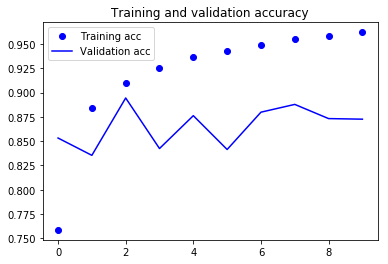

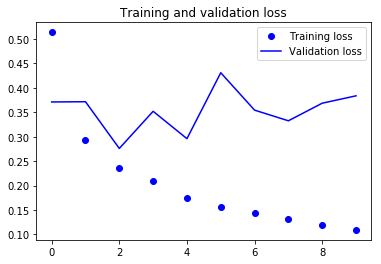

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

提醒一下，在第 3 章，处理这个数据集的第一个简单方法得到的测试精度是 88%。不幸的是， 与这个基准相比，这个小型循环网络的表现并不好（验证精度只有 85%）。问题的部分原因在于， 输入只考虑了前 500 个单词，而不是整个序列，因此，RNN 获得的信息比前面的基准模型更少。 另一部分原因在于，SimpleRNN 不擅长处理长序列，比如文本。

其他类型的循环层的表现要好得多。我们来看几个更高级的循环层。


[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

## Keras 中一个 LSTM 的具体例子

现在我们来看一个更实际的问题：使用 LSTM 层来创建一个模型，然后在 IMDB 数据上 训练模型（见图 6-16 和图 6-17）。这个网络与前面介绍的 SimpleRNN 网络类似。你只需指定 LSTM 层的输出维度，其他所有参数（有很多）都使用 Keras 默认值。Keras 具有很好的默认值， 无须手动调参，模型通常也能正常运行。


In [9]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 159s 8ms/step - loss: 0.5138 - acc: 0.7586 - val_loss: 0.3711 - val_acc: 0.8532
Epoch 2/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.2932 - acc: 0.8845 - val_loss: 0.3716 - val_acc: 0.8354
Epoch 3/10
20000/20000 [==============================] - 158s 8ms/step - loss: 0.2352 - acc: 0.9094 - val_loss: 0.2759 - val_acc: 0.8944
Epoch 4/10
20000/20000 [==============================] - 152s 8ms/step - loss: 0.2097 - acc: 0.9252 - val_loss: 0.3520 - val_acc: 0.8424
Epoch 5/10
20000/20000 [==============================] - 158s 8ms/step - loss: 0.1744 - acc: 0.9365 - val_loss: 0.2960 - val_acc: 0.8762
Epoch 6/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.1556 - acc: 0.9423 - val_loss: 0.4309 - val_acc: 0.8414
Epoch 7/10
20000/20000 [==============================] - 156s 8ms/step - loss: 0.1435 - acc: 0.9491 - val_loss: 0.3543 - v

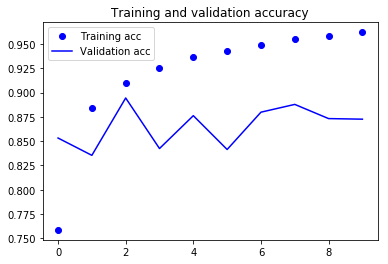

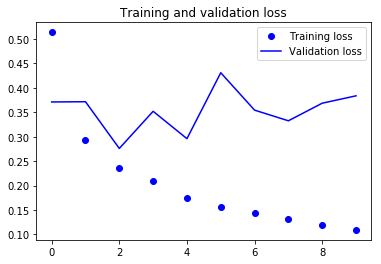

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

这一次，验证精度达到了 87%。还不错，肯定比 SimpleRNN 网络好多了，这主要是因为LSTM 受梯度消失问题的影响要小得多。这个结果也比第 3 章的全连接网络略好，虽然使用的数据量比第 3 章要少。此处在 500 个时间步之后将序列截断，而在第 3 章是读取整个序列。 

但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。为什么 LSTM 不能表现得更好？一个原因是你没有花力气来调节超参数，比如嵌入维度或 LSTM 输出维度。另 一个原因可能是缺少正则化。

但说实话，主要原因在于，适用于评论分析全局的长期性结构（这 正是 LSTM 所擅长的），对情感分析问题帮助不大。对于这样的基本问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。但还有更加困 难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。
